## Table of Contents
[1.0 Import Statements](#Import-Statements)<br>
[2.0 Data Preparation](#Data-Preparation)<br>
[2.1 Label Encode Categorical Columns ](#categorical)<br>

### 1.0 Import Statements <a class="anchor" id="Import-Statements"></a>

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor

# Import split_data
os.chdir('../scripts')
from functions import split_data, sMAPE, compute_metrics, r2
os.chdir('../notebooks')

### 1.2 Import Functions

### 1.3 Import Data

In [3]:
#df = pd.read_csv('../data/clean/df_clean.csv', index_col=0, parse_dates=True)
df_lag = pd.read_csv('../data/clean/df_clean_lag.csv', index_col=0, parse_dates=True)

### 2.0 Data Preparation <a class="anchor" id="Data-Preparation"></a>
### 2.1 Label Encode Categorical Columns <a class="anchor" id="categorical"></a>

In [3]:
# Get Categorical columns
categorical = df_lag.select_dtypes(include='object')

# Instationate wind_dir_coder LabelEncoder, fit
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df_lag['wind_madrid_lag'])

# Transform wind_direction cols
for col in categorical.filter(regex='wind').columns:
    df_lag[col] = wind_dir_coder.transform(df_lag[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate condition_coder LabelEncoder, fit on stacked conditions
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)

# Transform condition cols
for col in categorical.filter(regex='condition').columns:
    df_lag[col] = condition_coder.transform(df_lag[col])

# 3 Modeling
## 3.1 Univariate Regression - Predict Average Price
## Remove Columns in Preparation for Univariate Regression

In [4]:
price_cols = df_lag.filter(regex='price').columns.to_list()[1:]
price_cols.remove('price_day_ahead')
data = df_lag.drop(columns=price_cols)

## Multicolinearity

In [5]:
# Create correlation matrix
corr = data.drop(columns='price_actual').corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_price = data.corr()['price_actual'].reset_index().sort_values('price_actual', ascending=False)

# Rename correlation column
corr.rename(columns={0:'cor'}, inplace=True)

# Remove correlation between same variables and duplicates
corr = corr.loc[corr['cor']!=1]
corr.drop_duplicates(subset='cor', inplace=True)
corr_price = corr_price.loc[corr_price['price_actual']!=1]

# Reset index
corr.reset_index(drop=True, inplace=True)
corr_price.reset_index(drop=True, inplace=True)

# Round
corr.cor =corr.cor.apply(lambda x: round(x,3))

In [6]:
corr.head(50)

,level_0,level_1,cor
0,load_forecast,load_actual,0.995
1,solar_forecast,solar_lag,0.965
2,temp_valencia_lag,temp_barcelona_lag,0.919
3,temp_barcelona_lag,temp_madrid_lag,0.906
4,temp_valencia_lag,temp_madrid_lag,0.897
5,temp_barcelona_lag,dew_point_barcelona_lag,0.878
6,coal/lignite_lag,coal_lag,0.860
7,dew_point_barcelona_lag,dew_point_valencia_lag,0.855
8,load_forecast,generation_forecast,0.854
9,generation_forecast,load_actual,0.853


Get the pairs of variables highly correlated with each other, and for each pair, drop the one with the lower correlation with `price_actual`

In [7]:
drop = []
for row in range(len(corr.loc[corr.cor>.8])):
    var1 = corr.loc[row,'level_0']
    var2 = corr.loc[row,'level_1']
    
    # Get var corrs with price_tomorrow
    var1_corr = float(corr_price.loc[corr_price['index'] == var1, 'price_actual'])
    var2_corr = float(corr_price.loc[corr_price['index'] == var2, 'price_actual'])
    
    # Add the lower correlation to the drop list
    if var1_corr > var2_corr:
        drop.append(var2)
    else:
        drop.append(var1)

Drop highly correlated weather columns

In [8]:
data.drop(columns=drop, inplace=True)

In [9]:
# Create correlation matrix
corr = data.drop(columns='price_actual').corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_price = data.corr()['price_actual'].reset_index().sort_values('price_actual', ascending=False)

# Rename correlation column
corr.rename(columns={0:'cor'}, inplace=True)

# Remove correlation between same variables and duplicates
corr = corr.loc[corr['cor']!=1]
corr.drop_duplicates(subset='cor', inplace=True)
corr_price = corr_price.loc[corr_price['price_actual']!=1]

# Reset index
corr.reset_index(drop=True, inplace=True)
corr_price.reset_index(drop=True, inplace=True)

# Round
corr.cor =corr.cor.apply(lambda x: round(x,3))

In [10]:
corr_price

,index,price_actual
0,price_day_ahead,0.996753
1,gas_lag,0.322672
2,biomass_lag,0.313816
3,load_actual,0.175029
4,renewable_lag,0.174763
5,waste_lag,0.129069
6,transmission_sf_lag,0.072906
7,transmission_sp_lag,0.069635
8,pressures_barcelona_lag,0.065917
9,pressures_bilbao_lag,0.063930


In [11]:
corr.head(60)

,level_0,level_1,cor
0,humidities_madrid_lag,humidities_seville_lag,0.775
1,dew_point_bilbao_lag,dew_point_valencia_lag,0.762
2,pressures_barcelona_lag,pressures_madrid_lag,0.753
3,pressures_valencia_lag,pressures_barcelona_lag,0.731
4,transmission_fs_lag,transmission_sf_lag,0.661
5,temp_seville_lag,humidities_madrid_lag,0.654
6,dew_point_madrid_lag,dew_point_valencia_lag,0.652
7,dew_point_madrid_lag,dew_point_bilbao_lag,0.649
8,pressures_bilbao_lag,pressures_valencia_lag,0.640
9,wind_forecast,onshore_lag,0.630


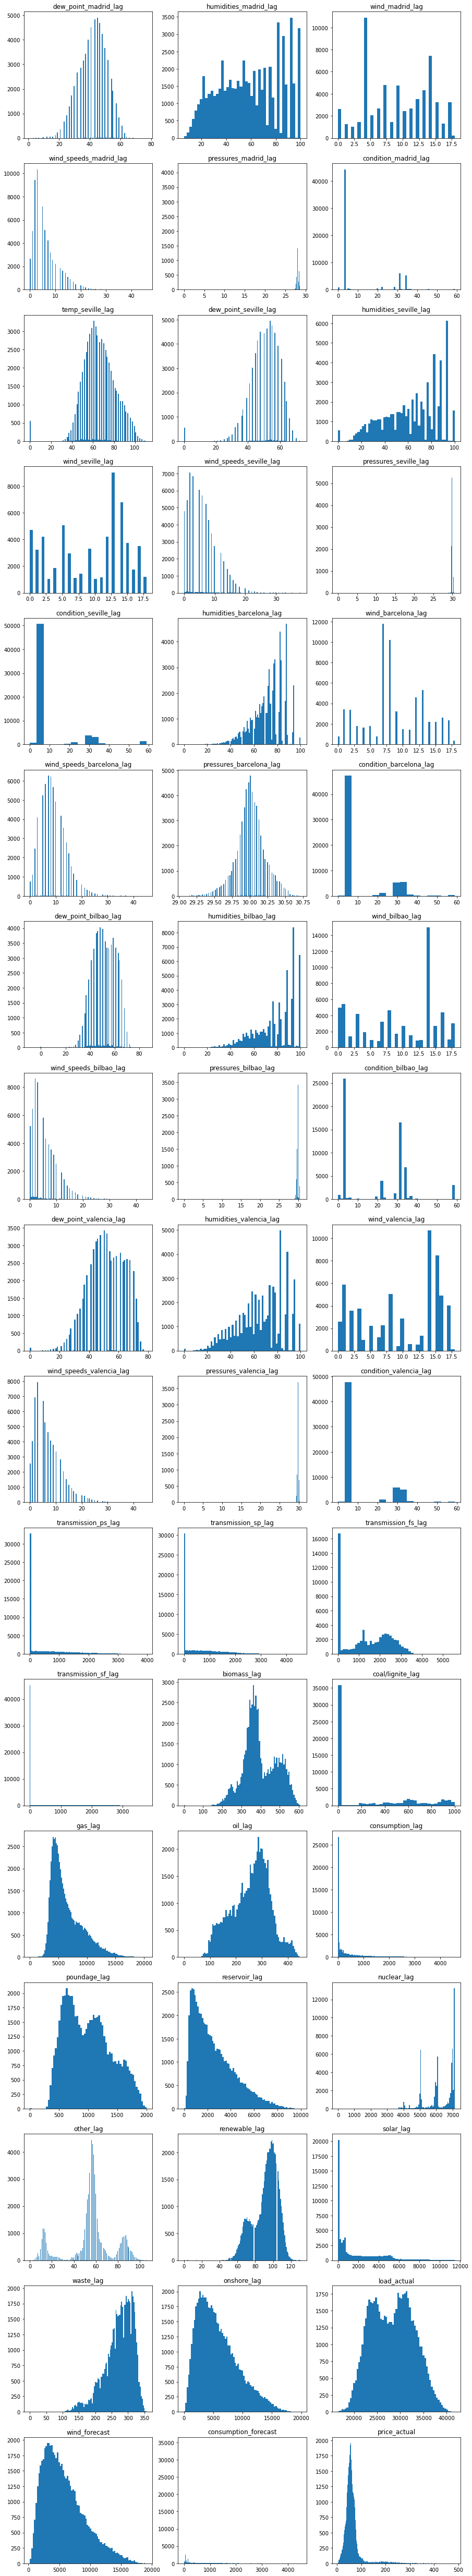

In [12]:
fig, axes = plt.subplots(nrows=data.shape[1]//3, ncols=3, figsize=(15,90));
for col, ax in zip(data.columns, axes.flatten()):
    ax.hist(data[col], bins='auto')
    ax.set_title(col)

## Split Data

In [13]:
X_train, y_train, X_val, y_val = split_data(data, 2020, 'price_actual')

In [14]:
results_actual = pd.DataFrame(index=['Parameters','sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])
results_actual['TSO_prediction'] = ['None',
                                    round(sMAPE(y_train, df_lag.loc[:'2019', 'price_day_ahead']), 3),
                                    round(sMAPE(y_val, df_lag.loc['2020', 'price_day_ahead']), 3),
                                    round(r2(y_train, df_lag.loc[:'2019', 'price_day_ahead']), 3), 
                                    round(r2(y_val, df_lag.loc['2020', 'price_day_ahead']),3)]
results_actual

,TSO_prediction
Parameters,None
sMAPE_train,16.03
sMAPE_val,16.922
r2_train,0.954
r2_val,0.971


## Linear Regression

In [22]:
lasso = Lasso(max_iter=10000)
lasso.fit(X_train, y_train)

Lasso(max_iter=10000)

In [23]:
results_actual['lasso'] = compute_metrics(lasso, {'max_iter':10000}, (X_train, y_train), (X_val, y_val))
results_actual

,TSO_prediction,lasso
Parameters,None,{'max_iter': 10000}
sMAPE_train,16.03,3.021123
sMAPE_val,16.922,5.868778
r2_train,0.954,0.976826
r2_val,0.971,0.972601


In [24]:
# Get Coefficients and add to df
coefs = pd.DataFrame({'coefficients': lasso.coef_}, index=X_train.columns)

# Add flag for if negative, and take absolute values, then sort
coefs['key'] = coefs.coefficients.apply(lambda x: 'positive' if x > 0 else 'negative')
coefs.coefficients = abs(coefs.coefficients)
coefs.sort_values(by='coefficients', ascending=False, inplace=True)

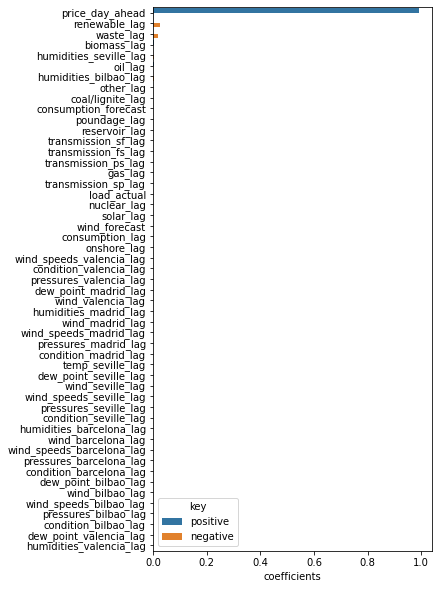

In [25]:
# Plot the coefficients on bar chart
plt.figure(figsize=(5,10))
sns.barplot(y=coefs.index, x=coefs.coefficients, data= coefs, hue='key');
plt.xticks();

In [26]:
coefs.head()

,coefficients,key
price_day_ahead,0.990312,positive
renewable_lag,0.024627,negative
waste_lag,0.017299,negative
biomass_lag,0.004259,positive
humidities_seville_lag,0.004222,negative


### Feature Selection

In [27]:
sMAPE_lasso = []
for i in range(1, len(X_train.columns)):
    lasso_temp = Lasso(max_iter = 10000)
    selector = RFE(lasso_temp, n_features_to_select=i)
    selector = selector.fit(X_train, y_train)
    cols = X_train.columns[selector.support_]
    lasso_temp.fit(X_train[cols], y_train)

    preds = lasso_temp.predict(X_val[cols])
    sMAPE_lasso.append(sMAPE(y_val, preds))

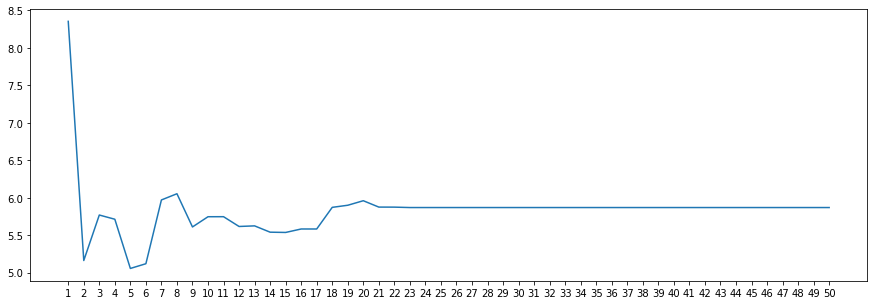

In [28]:
fig = plt.figure(figsize=(15,5))
plt.plot(range(1, len(X_train.columns)), sMAPE_lasso);
plt.xticks(range(1,len(X_train.columns)));

### Rerun with top three features

In [29]:
lasso1 = Lasso(max_iter = 10000)
lasso_rfe = RFE(lasso1, n_features_to_select=5)
lasso_rfe = lasso_rfe.fit(X_train, y_train)
lasso_cols = X_train.columns[lasso_rfe.support_]
lasso1.fit(X_train[lasso_cols], y_train)


results_actual['lasso1'] = compute_metrics(lasso1,
                                           {'max_iter':10000, 'num_predictors':5},
                                           (X_train[lasso_cols], y_train),
                                           (X_val[lasso_cols], y_val))
results_actual

,TSO_prediction,lasso,lasso1
Parameters,None,{'max_iter': 10000},"{'max_iter': 10000, 'num_predictors': 5}"
sMAPE_train,16.03,3.021123,3.367383
sMAPE_val,16.922,5.868778,5.056031
r2_train,0.954,0.976826,0.971238
r2_val,0.971,0.972601,0.968525


In [30]:
# Get Coefficients and add to df
lasso1_coefs = pd.DataFrame({'coefficient': lasso1.coef_}, index=X_train[lasso_cols].columns)

# Add flag for if negative, and take absolute values, then sort
lasso1_coefs['key'] = lasso1_coefs.coefficient.apply(lambda x: 'positive' if x > 0 else 'negative')
lasso1_coefs.coefficient = abs(lasso1_coefs.coefficient)
lasso1_coefs.sort_values(by='coefficient', ascending=False, inplace=True)
lasso1_coefs

,coefficient,key
price_day_ahead,0.987864,positive
renewable_lag,0.065059,negative
waste_lag,0.017606,negative
humidities_bilbao_lag,0.013079,negative
oil_lag,0.009918,positive


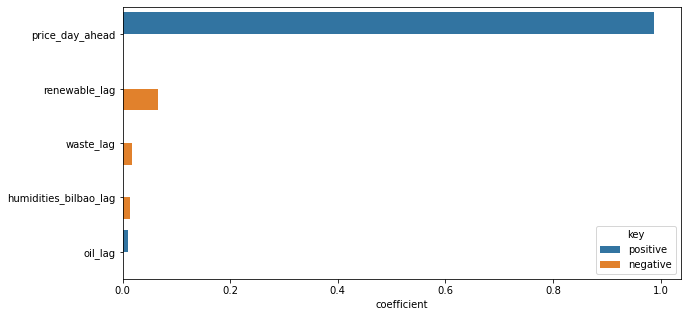

In [31]:
# Plot the coefficients on bar chart
plt.figure(figsize=(10,5))
sns.barplot(y=lasso1_coefs.index, x=lasso1_coefs.coefficient, data= lasso1_coefs, hue='key');
plt.xticks();

### Predict Residual


In [32]:
# Define the price_residual
data['price_residual'] = data.price_day_ahead - data.price_actual

# Split the data into train, validation
X_train, y_train, X_val, y_val = split_data(data.drop(columns=['price_actual', 'price_day_ahead']), 2020, 'price_residual')

### Create results_residual dataframe

In [33]:
results_resid = pd.DataFrame(index=['Parameters','sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

In [46]:
# Instantiate Lasso model, fit
lasso_r = Lasso(max_iter=10000)
lasso_r.fit(X_train, y_train)

# Compute metrics and add to results table
results_resid['lasso_r']= compute_metrics(lasso_r, 'None', (X_train, y_train), (X_val, y_val))
results_resid

,lasso_r,lasso_r1,lasso_r2,lasso_r3,lasso_r4
Parameters,None,"{'max_iter': 10000, 'alpha': 10}","{'max_iter': 10000, 'alpha': 100}","{'max_iter': 10000, 'alpha': 1000}","{'max_iter': 10000, 'alpha': 1000, 'num_cols':..."
sMAPE_train,21.139113,21.594288,24.696436,27.476611,29.556556
sMAPE_val,36.372747,42.055513,38.660332,41.514587,44.772122
r2_train,0.511001,0.490156,0.326331,0.204438,0.095721
r2_val,0.12625,0.110064,0.101385,0.050666,0.032036


In [47]:
# Instantiate Lasso model, fit
lasso_r1 = Lasso(max_iter=10000, alpha=10)
lasso_r1.fit(X_train, y_train)

# Compute metrics and add to results table
results_resid['lasso_r1']= compute_metrics(lasso_r1, 
                                           {'alpha':10}, 
                                           (X_train, y_train), 
                                           (X_val, y_val))
results_resid

,lasso_r,lasso_r1,lasso_r2,lasso_r3,lasso_r4
Parameters,None,{'alpha': 10},"{'max_iter': 10000, 'alpha': 100}","{'max_iter': 10000, 'alpha': 1000}","{'max_iter': 10000, 'alpha': 1000, 'num_cols':..."
sMAPE_train,21.139113,21.594288,24.696436,27.476611,29.556556
sMAPE_val,36.372747,42.055513,38.660332,41.514587,44.772122
r2_train,0.511001,0.490156,0.326331,0.204438,0.095721
r2_val,0.12625,0.110064,0.101385,0.050666,0.032036


In [48]:
# Instantiate Lasso model, fit
lasso_r2 = Lasso(max_iter=10000, alpha=100)
lasso_r2.fit(X_train, y_train)

# Compute metrics and add to results table
results_resid['lasso_r2']= compute_metrics(lasso_r2, 
                                           {'alpha':100},
                                           (X_train, y_train), 
                                           (X_val, y_val))
results_resid

,lasso_r,lasso_r1,lasso_r2,lasso_r3,lasso_r4
Parameters,None,{'alpha': 10},{'alpha': 100},"{'max_iter': 10000, 'alpha': 1000}","{'max_iter': 10000, 'alpha': 1000, 'num_cols':..."
sMAPE_train,21.139113,21.594288,24.696436,27.476611,29.556556
sMAPE_val,36.372747,42.055513,38.660332,41.514587,44.772122
r2_train,0.511001,0.490156,0.326331,0.204438,0.095721
r2_val,0.12625,0.110064,0.101385,0.050666,0.032036


In [49]:
# Instantiate Lasso model, fit
lasso_r3 = Lasso(max_iter=10000, alpha=1000)
lasso_r3.fit(X_train, y_train)

# Compute metrics and add to results table
results_resid['lasso_r3']= compute_metrics(lasso_r3, 
                                           {'alpha':1000},
                                           (X_train, y_train), 
                                           (X_val, y_val))
results_resid

,lasso_r,lasso_r1,lasso_r2,lasso_r3,lasso_r4
Parameters,None,{'alpha': 10},{'alpha': 100},{'alpha': 1000},"{'max_iter': 10000, 'alpha': 1000, 'num_cols':..."
sMAPE_train,21.139113,21.594288,24.696436,27.476611,29.556556
sMAPE_val,36.372747,42.055513,38.660332,41.514587,44.772122
r2_train,0.511001,0.490156,0.326331,0.204438,0.095721
r2_val,0.12625,0.110064,0.101385,0.050666,0.032036


In [54]:
# Instantiate lasso model
lasso_r4 = Lasso(max_iter=10000, alpha=1000)

# Instantiate RFE set to 10 features to select
selector = RFE(lasso_temp, n_features_to_select=10)

# Select most important 10 features then fit lasso model
selector.fit(X_train, y_train)
r4_cols = X_train.columns[selector.support_]
lasso_r4.fit(X_train[r4_cols], y_train)

# Compute metrics and add to table
results_resid['lasso_r4']= compute_metrics(lasso_r4, 
                                           {'alpha':1000,
                                            'num_cols':10},
                                           (X_train[r4_cols], y_train), 
                                           (X_val[r4_cols], y_val))
results_resid

,lasso_r,lasso_r1,lasso_r2,lasso_r3,lasso_r4
Parameters,None,{'alpha': 10},{'alpha': 100},{'alpha': 1000},"{'alpha': 1000, 'num_cols': 10}"
sMAPE_train,21.139113,21.594288,24.696436,27.476611,29.556556
sMAPE_val,36.372747,42.055513,38.660332,41.514587,44.772122
r2_train,0.511001,0.490156,0.326331,0.204438,0.095721
r2_val,0.12625,0.110064,0.101385,0.050666,0.032036


In [55]:
# Instantiate lasso model
lasso_r5 = Lasso(max_iter=10000, alpha=1000)

# Instantiate RFE set to 10 features to select
selector = RFE(lasso_temp, n_features_to_select=2)

# Select most important 10 features then fit lasso model
selector.fit(X_train, y_train)
r5_cols = X_train.columns[selector.support_]
lasso_r5.fit(X_train[r5_cols], y_train)

# Compute metrics and add to table
results_resid['lasso_r5']= compute_metrics(lasso_r5, 
                                           {'alpha':1000,
                                            'num_cols':2},
                                           (X_train[r5_cols], y_train), 
                                           (X_val[r5_cols], y_val))
results_resid

,lasso_r,lasso_r1,lasso_r2,lasso_r3,lasso_r4,lasso_r5
Parameters,None,{'alpha': 10},{'alpha': 100},{'alpha': 1000},"{'alpha': 1000, 'num_cols': 10}","{'alpha': 1000, 'num_cols': 2}"
sMAPE_train,21.139113,21.594288,24.696436,27.476611,29.556556,30.546269
sMAPE_val,36.372747,42.055513,38.660332,41.514587,44.772122,44.431389
r2_train,0.511001,0.490156,0.326331,0.204438,0.095721,0.0
r2_val,0.12625,0.110064,0.101385,0.050666,0.032036,0.0


**Evaluation**:
* Increasing regularization using `alpha` did not seem to decrease overfitting
* Using RFE to select decreasing number of columns also did not decrease overfitting, and also decreased performance of the model
* The best Lasso model is the vanilla model

In the end, no amount of regularization nor selection of features seemed to decrease the overfitting problem. This indicates that our data does not have a strong relationship with `price_residual`. `Price_residual` is more likely just noise.  To that end, there's one more thing to try.  We can use a MultiOutputRegressor to set up models to predict each price component individually.  While there was no ascertainable relationship between our data and the residual, there may be a relationship between the data and one or multiple of the components.

### Modeling Individual Price Components

### Split Data

In [60]:
X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=['price_actual', 'price_day_ahead']), 2020, price_cols)

### Train MultiOutputRegressor Model

In [64]:
# Instantiate Lasso and Multioutput Regressor
lasso = Lasso(max_iter=10000)
l_multi = MultiOutputRegressor(lasso)

# Fit the Regressor
l_multi.fit(X_train, y_train)

# Get the predictions
preds_train = l_multi.predict(X_train)
preds_val = l_multi.predict(X_val)


C:\Users\holde\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


Were are getting a convergence warning since we could not arrive at a solution for a few of targets. In other words, the data does not do a good job predicting a few of the components, which is expected since we were unsucessful in modeling the residual.  Let's see which components we were able to model.  I'll create a dataframe which shows the targets and their corresponding metrics in the columns

In [67]:
# Create results table
results_comp = pd.DataFrame(index=['Parameters','sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

# Add metric results to results table
for i, model in enumerate(l_multi.estimators_):    
    results_comp[y_val.columns[i]] = compute_metrics(model,'None',(X_train,y_train.iloc[:,i]), (X_val, y_val.iloc[:,i]))
results_comp.T.sort_values(by='sMAPE_val')

C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\holde\flatiron\capstone\scripts\functions.py:306: RuntimeWarning: invalid value encountered in true_divide
  return 100/(len(y_true)) * (abs(y_pred - y_true)/((abs(y_true)+abs(y_pred))/2)).sum()
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
price_power_factor,None,11.594499,16.075969,0.379981,0.008525
price_capacity_payment,None,34.370693,36.169393,0.627607,0.644519
price_PBF_tech,None,47.028941,38.658505,0.548828,0.430642
price_sec_reserve,None,44.785157,58.789873,0.462561,0.413156
price_measured_imbalances,None,90.577781,85.027981,0.025994,0.067456
price_imbalances_net,None,126.290044,117.526601,0.030195,0.017233
price_balance_failure,None,132.611224,127.991536,0.02239,0.004604
price_intraday_market,None,153.808137,140.104392,0.025552,0.013607
price_P0146_balance,None,173.384199,167.903967,0.008031,0.004585
price_rt_tech,None,162.143541,172.660406,0.039345,0.009574


The first four components seem to have some tangible relationship with the data (`price_power_factor`, `price_capacity_payment`, `price_PBF_tech`, `price_sec_reserve`). Now let's train a MultiOutputRegressor on these four targets.  We can then add the their results to `price_day_ahead` and compare the results with our best univariate model.

In [94]:
# Get targets
multi_targets = ['price_power_factor', 'price_capacity_payment', 'price_PBF_tech', 'price_sec_reserve']

# Get price cols to drop
drop_cols = list(set(df_lag.filter(regex='price').columns.to_list()) - set(multi_targets))

X_train, y_train, X_val, y_val = split_data(df_lag.drop(columns=drop_cols), 2020, multi_targets)

In [95]:
# Instantiate Lasso and Multioutput Regressor
lasso = Lasso(max_iter=10000)
l_multi = MultiOutputRegressor(lasso)

# Fit the Regressor
l_multi.fit(X_train, y_train)

# Get the predictions
preds_train = l_multi.predict(X_train)
preds_val = l_multi.predict(X_val)

Notice there was no convergence warning this time since we dropped all the columns which did not have a relationship the data. Now let's combine the output from this MultiOutputRegressor with the `price_day_ahead` to get a prediction for the `actual_price`.

In [96]:
preds_train = preds_train.sum(axis=1) + df_lag.loc[:'2019', 'price_day_ahead']
preds_val = preds_val.sum(axis=1) + df_lag.loc['2020', 'price_day_ahead']

In [100]:
results_actual['lasso2'] = ['MultiOutputRegressor',
                            sMAPE(df_lag.loc[:'2019','price_actual'],preds_train),
                            sMAPE(df_lag.loc['2020','price_actual'],preds_val),
                            r2(df_lag.loc[:'2019','price_actual'],preds_train),
                            r2(df_lag.loc['2020','price_actual'],preds_val)]
results_actual

,TSO_prediction,lasso,lasso1,lasso2
Parameters,None,{'max_iter': 10000},"{'max_iter': 10000, 'num_predictors': 5}",MultiOutputRegressor
sMAPE_train,16.03,3.021123,3.367383,4.249187
sMAPE_val,16.922,5.868778,5.056031,4.117137
r2_train,0.954,0.976826,0.971238,0.975298
r2_val,0.971,0.972601,0.968525,0.971797


There was a slight improvement in both sMAPE and r2 when using the MultiOutputRegressor in tangem with lasso regression on four of the price components.